# 1. Install Required Libraries
## First, install the required libraries for TensorFlow, TensorFlow Hub, and Transformers.


In [ ]:
!pip install tensorflow tensorflow_text transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
from google.colab import files
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, BertTokenizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Upload files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving extracted_sentences.csv to extracted_sentences.csv
User uploaded file "extracted_sentences.csv" with length 2419786 bytes


In [ ]:
# Load the dataset
file_name = list(uploaded.keys())[0]  # Take the first uploaded file
df = pd.read_csv(file_name)

# Rename columns and handle missing values
df = df.rename(columns={'sentence': 'text', 'type': 'label'}).dropna()

# Map labels to integers
label_mapping = {'pro-israeli': 0, 'pro-palestinian': 1, 'neutral': 2}
df['new_label'] = df['label'].map(label_mapping)

# Drop rows with unmapped labels
if df['new_label'].isna().sum() > 0:
    print("Some labels could not be mapped. Please review `label_mapping`.")
    df = df.dropna(subset=['new_label'])

In [ ]:
df.head()

,id,text,label,new_label
0,aj_1,pope renews call for gaza ceasefire release of...,pro-palestinian,1
1,aj_5,the hospital was raided by israeli forces befo...,pro-israeli,0
2,aj_10,the discovery of a mass grave inside the nasse...,pro-palestinian,1
3,aj_13,the propalestinian demonstrators were quickly ...,pro-palestinian,1
4,aj_18,thirteen out of 21 people killed by israel in ...,pro-israeli,0


In [ ]:
# Use only the first 100 lines
df = df[:100]

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 128

# Tokenization function
def tokenize_data(texts, labels, tokenizer, max_len):
    encoding = tokenizer(
        list(texts),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )
    return (
        {
            "input_ids": encoding["input_ids"],
            "attention_mask": encoding["attention_mask"]
        },
        tf.convert_to_tensor(labels, dtype=tf.int32)
    )

# Tokenize datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    tokenize_data(train_df['text'], train_df['new_label'], tokenizer, max_len)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    tokenize_data(test_df['text'], test_df['new_label'], tokenizer, max_len)
)

# Batch and prefetch datasets
batch_size = 16
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load the model
model = TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3  # Assuming 3 unique labels
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Train the model with a progress bar
from tqdm import tqdm

EPOCHS = 2
history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

Epoch 1/2
5/5 [==============================] - 86s 13s/step - loss: 1.0373 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.9387 - val_sparse_categorical_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 6s 3s/step - loss: 0.8090 - sparse_categorical_accuracy: 0.6667
Test Loss: 0.808954119682312
Test Accuracy: 0.6666666865348816


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

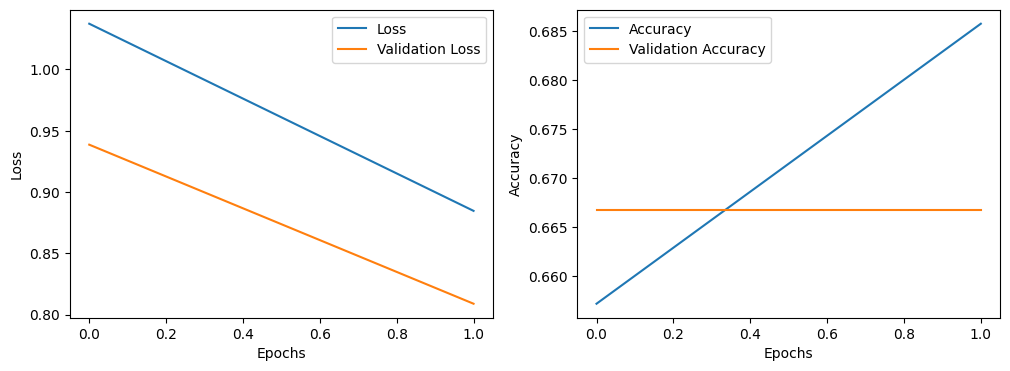

In [ ]:

# Visualization Section
# Plotting loss and accuracy
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

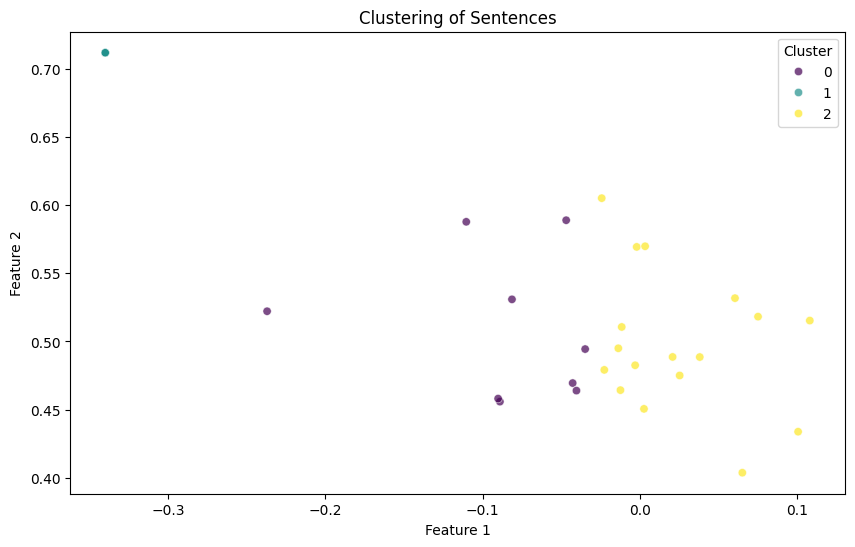

In [ ]:
# Clustering and Visualization Section
# Extract features
def extract_features(dataset):
    features = []
    labels = []
    for texts, labels_batch in dataset:
        pooled_output = model(texts)[0]  # Assuming `model` outputs a tuple with [0] containing pooled output
        features.append(pooled_output.numpy())
        labels.append(labels_batch.numpy())
    return tf.concat(features, axis=0), tf.concat(labels, axis=0)

features, labels = extract_features(test_dataset)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=clusters, palette='viridis', alpha=0.7)
plt.title('Clustering of Sentences')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

Some layers from the model checkpoint at ./saved_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./saved_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'dataset' is not defined